In [65]:
import numpy as np
import math
import pandas as pd
#from model import *
import csv
import matplotlib.pyplot as plt
import pickle


import numpy as np


class NN(object):
    def __init__(self, layers = [10 , 20, 1], activations=['sigmoid', 'relu'], usage = 'regression'):
        assert(len(layers) == len(activations)+1)
        self.layers = layers
        self.activations = activations
        self.weights = []
        self.biases = []
        self.usage = usage
        for i in range(len(layers)-1):
            self.weights.append(np.random.randn(layers[i+1], layers[i])*0.1) #the *0.1 is impmortant
            self.biases.append(np.random.randn(layers[i+1], 1)*0.1)

    def feedforward(self, x): #x = dim*num
        ai = np.copy(x)
        z_s = []
        a_s = [ai]
        for i in range(len(self.weights)):
            #activation_function = self.AF(self.activations[i])
            z_s.append(self.weights[i].dot(ai) + self.biases[i])
            ai = self.AF(self.activations[i])(z_s[-1])
            a_s.append(ai)
        return (z_s, a_s)

    def backpropagation(self,y, z_s, a_s): #y = 1*num
        dw = []  # dC/dW
        db = []  # dC/dB
        deltas = [None] * len(self.weights)  # delta = dC/dZ, error for each layer

        #out delta measurement =
        delta_out = y- a_s[-1]
        #last layer delta
        deltas[-1] = delta_out*(self.dAF(self.activations[-1]))(z_s[-1])
        #backpro
        for i in reversed(range(len(deltas)-1)):
            deltas[i] = self.weights[i+1].T.dot(deltas[i+1])*(self.dAF(self.activations[i])(z_s[i]))
        batch_size = y.shape[1]
        db = [d.dot(np.ones((batch_size,1)))/float(batch_size) for d in deltas]
        dw = [d.dot(a_s[i].T)/float(batch_size) for i,d in enumerate(deltas)]
        #db = [d.dot(np.ones((batch_size,1))) for d in deltas]
        #dw = [d.dot(a_s[i].T) for i,d in enumerate(deltas)]
        # return the derivitives respect to weight matrix and biases
        #print(db)
        #print(dw)
        return dw, db

    def train(self, x, y, batch_size=10, epochs=100, lr = 0.1): #x = num*dim #y = num*dim
        #record cost by epchos
        learning_curve = []

        #mini batch
        #assert(x.shape[0] >= batch_size*epochs)
        indices = np.arange(x.shape[0])#debug if 0
        np.random.shuffle(indices)
        x = x[indices]
        y = y[indices]

        for e in range(epochs):
            i=0
            #print("len y  ", len(y))
            while(i<len(y)):
                x_batch = x[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                x_batch = x_batch.T
                y_batch = y_batch.T
                #print(x_batch.shape)
                #print(y_batch.shape)
                i += batch_size
                z_s, a_s = self.feedforward(x_batch)
                dw, db = self.backpropagation(y_batch, z_s, a_s)
                self.weights = [wi+lr*dwi for wi,dwi in  zip(self.weights, dw)]
                self.biases = [bi+lr*dbi for bi,dbi in  zip(self.biases, db)]
                loss = self.J(self.usage)(a_s[-1],y_batch)
            #if(e%(epochs/10)== 0):
            learning_curve.append(loss) #to expand
            #print("loss = {}".format(np.linalg.norm(a_s[-1]-y_batch))) #to expand
        return learning_curve


    def calc_error(self, test_X, test_y): #num*dim
        _, a_s = self.feedforward(test_X.T)
        return  self.J(self.usage)(a_s[-1], test_y.T)

    def prediction(self, X): #num*dim
        _, a_s = self.feedforward(X.T)
        return a_s[-1]

    @staticmethod
    def AF(name):
        if(name == 'sigmoid'):
            def sig(x):
                x = np.clip(x , -500, 500)
                return np.exp(x)/(1+np.exp(x))
            return sig
        elif(name == 'linear'):
            return lambda x : x
        elif(name == 'relu'):
            def relu(x):
                y = np.copy(x)
                y[y<0] = 0
                return y
            return relu
        else:
            print('unknown activation function => linear')
            return lambda x: x

    @staticmethod
    def dAF(name):
        if(name == 'sigmoid'):
            def dsig(x):
                x = np.clip(x , -500, 500)
                sigx = np.exp(x)/(1+np.exp(x))
                return sigx*(1-sigx)
            return dsig
        elif(name == 'linear'):
            return lambda x: 1
        elif(name == 'relu'):
            def drelu(x):
                y = np.copy(x)
                y[y>=0] = 1
                y[y<0] = 0
                return y
            return drelu
        else:
            print('unknown activation function => linear derivative')
            return lambda x: 1

    @staticmethod
    def dJ(name):
        if(name == 'regression'):
            return lambda x, y: y-x
        if(name == 'classification'):
            return lambda x, y: np.divide(y, x) - np.divide(1 - y, 1 - x)
        else:
            print('unknown usage => regression')
            return lambda x, y: y-x

    @staticmethod
    def J(name):
        if(name == 'regression'):
            return lambda x, y: np.sqrt(np.linalg.norm(y-x)/max(y.shape[0], y.shape[1])) #RMS
        if(name == 'classification'):
            return lambda x, y: np.divide(y, x) - np.divide(1 - y, 1 - x)
        else:
            print('unknown usage => regression')
            return lambda x, y: np.sqrt(np.linalg.norm(y-x)/np.max(y.shape[0], y.shape[1]))


In [66]:
#preprocessing

df = pd.read_csv("EnergyEfficiency_data.csv")
df

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28
...,...,...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,5,0.4,5,17.88,21.40
764,0.62,808.5,367.5,220.50,3.5,2,0.4,5,16.54,16.88
765,0.62,808.5,367.5,220.50,3.5,3,0.4,5,16.44,17.11
766,0.62,808.5,367.5,220.50,3.5,4,0.4,5,16.48,16.61


In [67]:
def get_onehot(df, name):
    A = df[name].values
    n = A.shape[0]
    onehot_A = np.zeros((n,max(A)-min(A)+1))
    onehot_A[np.arange(n), A-min(A)] = 1
    return onehot_A

def normalize(X):
    s = [ np.mean(dim) for dim in X.T]
    X = np.asarray([np.divide(x, s) for x in X])
    return X

O = get_onehot(df, "Orientation")
G = get_onehot(df, "Glazing Area Distribution")
y = df["Heating Load"].values.reshape((-1,1))
y.shape
Other = df.drop(['Orientation', 'Glazing Area Distribution', "Heating Load"], axis=1).values

X = np.c_[normalize(Other), O, G]
assert(X.shape[1] == O.shape[1]+G.shape[1]+Other.shape[1])

def partition(X, y, ratio=0.7):
    n = X.shape[0]
    indices = np.arange(n)
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    p = int(n*ratio)
    train_X = X[:p]
    test_X = X[p:]
    train_y = y[:p]
    test_y = y[p:]
    return train_X, train_y, test_X, test_y

train_X, train_y, test_X, test_y = partition(X, y, ratio=0.7)

In [80]:
nn = NN([17, 15, 5, 1],activations=['sigmoid', 'sigmoid', 'relu'], usage = 'regression')

learning_curve = nn.train(train_X, train_y, epochs=70, batch_size=10, lr = .1)

train_RMS = nn.calc_error(train_X, train_y)
test_RMS = nn.calc_error(test_X, test_y)

In [81]:
_, a_s = nn.feedforward(X.T)

In [82]:
savefilename = "savenn"
with open(savefilename, 'wb') as fo:
    pickle.dump(nn, fo)

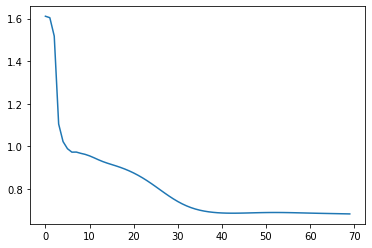

In [83]:
plt.plot(np.arange(len(learning_curve)), learning_curve)

In [84]:
print(train_RMS, test_RMS)

0.23558955736275677 0.30085837873996324
